In [ ]:
# System and Data Handling Imports
import os
import shutil
import numpy as np # type: ignore
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import cv2

In [2]:
# Skimage Imports for Image Processing
from skimage import exposure

# TensorFlow and Keras Imports for Model Building and Training
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, BackupAndRestore
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1_l2

In [3]:
# Scikit-learn Imports for Metrics and Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [4]:
!pip install -q kaggle

In [5]:
from google.colab import files
files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"salmazain","key":"402466f47c34f736d424d947c521e621"}'}

In [6]:
import os

# Rename the file
os.rename("kaggle (1).json", "kaggle.json")

In [7]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d aryashah2k/mango-leaf-disease-dataset

Dataset URL: https://www.kaggle.com/datasets/aryashah2k/mango-leaf-disease-dataset
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
  0% 0.00/103M [00:00<?, ?B/s]
100% 103M/103M [00:00<00:00, 1.33GB/s]


In [9]:
!ls

kaggle.json  mango-leaf-disease-dataset.zip  sample_data


In [10]:
!unzip -qq *.zip

In [11]:
!ls

 Anthracnose	    'Gall Midge'		     'Powdery Mildew'
'Bacterial Canker'   Healthy			      sample_data
'Cutting Weevil'     kaggle.json		     'Sooty Mould'
'Die Back'	     mango-leaf-disease-dataset.zip


In [12]:
source_dir = '/content'
destination_dir = '/content/mango_data'

mango_folders = [
    'Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back', 'Gall Midge',
    'Healthy', 'Powdery Mildew', 'Sooty Mould'
]

import os
import shutil

os.makedirs(destination_dir, exist_ok=True)

print("Copying mango disease folders...")
for folder in mango_folders:
    src_folder = os.path.join(source_dir, folder)
    dst_folder = os.path.join(destination_dir, folder)
    shutil.copytree(src_folder, dst_folder)
    print(f"✔️ Copied: {folder}")

print("\nFolders in /content/mango_data:")
print(os.listdir(destination_dir))

Copying mango disease folders...
✔️ Copied: Anthracnose
✔️ Copied: Bacterial Canker
✔️ Copied: Cutting Weevil
✔️ Copied: Die Back
✔️ Copied: Gall Midge
✔️ Copied: Healthy
✔️ Copied: Powdery Mildew
✔️ Copied: Sooty Mould

Folders in /content/mango_data:
['Anthracnose', 'Die Back', 'Cutting Weevil', 'Powdery Mildew', 'Bacterial Canker', 'Gall Midge', 'Sooty Mould', 'Healthy']


In [13]:
!ls /content/mango_data

 Anthracnose	    'Cutting Weevil'  'Gall Midge'  'Powdery Mildew'
'Bacterial Canker'  'Die Back'	       Healthy	    'Sooty Mould'


In [14]:
import os
import shutil
from sklearn.model_selection import train_test_split

def split_dataset(source_dir, destination_dir, train_size=0.8, val_size=0.1, test_size=0.1):
    splits = ['train', 'val', 'test']
    split_dirs = {split: os.path.join(destination_dir, split) for split in splits}

    # Create split directories
    for dir_path in split_dirs.values():
        os.makedirs(dir_path, exist_ok=True)

    for disease_class in os.listdir(source_dir):
        class_path = os.path.join(source_dir, disease_class)
        if not os.path.isdir(class_path):
            continue

        # Create class folders inside train/val/test
        for dir_path in split_dirs.values():
            os.makedirs(os.path.join(dir_path, disease_class), exist_ok=True)

        images = os.listdir(class_path)
        train_imgs, temp_imgs = train_test_split(images, train_size=train_size, random_state=42)
        val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

        for img_list, split in zip([train_imgs, val_imgs, test_imgs], splits):
            for image in img_list:
                src = os.path.join(class_path, image)
                dst = os.path.join(split_dirs[split], disease_class, image)
                shutil.copy(src, dst)


source_dir = '/content/mango_data'
destination_dir = '/content/mango_data_split'

split_dataset(source_dir, destination_dir)
print("Dataset split completed!")

Dataset split completed!


In [15]:
split_dataset_path = '/content/mango_data_split/train'  # change path to your mango train folder

class_names = [folder for folder in os.listdir(split_dataset_path)
               if os.path.isdir(os.path.join(split_dataset_path, folder))]

for class_name in class_names:
    class_path = os.path.join(split_dataset_path, class_name)
    num_images = len(os.listdir(class_path))
    print(f"{class_name}: {num_images} images")

Anthracnose: 400 images
Die Back: 400 images
Cutting Weevil: 400 images
Powdery Mildew: 400 images
Bacterial Canker: 400 images
Gall Midge: 400 images
Sooty Mould: 400 images
Healthy: 400 images


In [18]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import exposure

target_size = (224, 224)
batch_size = 32
num_classes = 8
channels = 3
epochs = 40

def contrast_stretching(image):
    p2, p98 = np.percentile(image, (2, 98))
    image = exposure.rescale_intensity(image, in_range=(p2, p98))
    return image

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest',
    channel_shift_range=30.0,
    shear_range=20.0
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.7, 1.3]
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.7, 1.3]
)

train_generator = train_datagen.flow_from_directory(
    '/content/mango_data_split/train',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    '/content/mango_data_split/val',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    '/content/mango_data_split/test',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 3200 images belonging to 8 classes.
Found 400 images belonging to 8 classes.
Found 400 images belonging to 8 classes.


In [19]:
from sklearn.utils.class_weight import compute_class_weight

# Compute the class weights based on the training data
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Convert to dictionary format
class_weight_dict = dict(enumerate(class_weights))

# Display the computed class weights
print("Class Weights:", class_weight_dict)

Class Weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0), 4: np.float64(1.0), 5: np.float64(1.0), 6: np.float64(1.0), 7: np.float64(1.0)}


In [20]:
class GradualUnfreezing(tf.keras.callbacks.Callback):
    def __init__(self, base_model, num_epochs_per_unfreeze=5):
        super().__init__()
        self.base_model = base_model
        self.num_epochs_per_unfreeze = num_epochs_per_unfreeze
        self.unfrozen_layers = 0

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.num_epochs_per_unfreeze == 0:
            if self.unfrozen_layers < len(self.base_model.layers):
                # Unfreeze 10 more layers every few epochs
                for layer in self.base_model.layers[-(self.unfrozen_layers + 10):]:
                    layer.trainable = True
                self.unfrozen_layers += 10
                print(f"\nUnfreezing layers: {self.unfrozen_layers}")

In [21]:
# Initialize ResNet50V2 base
base_model = ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=(target_size[0], target_size[1], channels)
)

# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

# Build model with residual connections
inputs = tf.keras.Input(shape=(target_size[0], target_size[1], channels))
x = base_model(inputs)

# Global pooling and initial dropout
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)

# First residual block
x1 = layers.Dense(512, activation='relu',
                  kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Dropout(0.15)(x1)
x_res = layers.Dense(512, activation='linear')(x)
x = layers.Add()([x_res, x1])
x = layers.Activation('relu')(x)

# Second residual block
x2 = layers.Dense(256, activation='relu',
                  kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x2 = layers.Dropout(0.1)(x2)
x_res2 = layers.Dense(256, activation='linear')(x)
x = layers.Add()([x_res2, x2])
x = layers.Activation('relu')(x)

# Output layer
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [22]:
initial_learning_rate = 1e-4
warmup_epochs = 5  # How many epochs to gradually increase the learning rate

def warmup_cosine_decay_schedule(epoch):
    if epoch < warmup_epochs:
        # Linearly increase learning rate during warm-up
        return initial_learning_rate * ((epoch + 1) / warmup_epochs)
    else:
        # Cosine decay after warm-up
        return initial_learning_rate * (
            0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (epochs - warmup_epochs)))
        )

In [23]:
callbacks = [
    # Stops training early if val_loss doesn't improve
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        min_delta=1e-4,
        verbose=1
    ),

    # Saves the best model based on validation accuracy
    tf.keras.callbacks.ModelCheckpoint(
        'best_CLDmodel_0109.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),

    # Custom learning rate schedule (warm-up + cosine decay)
    tf.keras.callbacks.LearningRateScheduler(warmup_cosine_decay_schedule),

    # Custom gradual unfreezing callback to fine-tune layers gradually
    GradualUnfreezing(base_model),

    # Backup the training progress (useful in Colab)
    tf.keras.callbacks.BackupAndRestore(backup_dir='./backup'),

    # TensorBoard log for training monitoring
    tf.keras.callbacks.TensorBoard(log_dir='./logs')
]

In [24]:
# Initialize optimizer with learning rate and weight decay
optimizer = AdamW(
    learning_rate=initial_learning_rate,
    weight_decay=1e-4
)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),  # label smoothing to improve generalization
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

In [25]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50v2          │ (None, 7, 7,      │ 23,564,800 │ input_layer_1[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50v2[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  1,049,088 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │  1,049,088 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 512)       │          0 │ dense_1[0][0],    │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 512)       │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    131,328 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │    131,328 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256)       │          0 │ dense_3[0][0],    │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256)       │          0 │ add_1[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 8)         │      2,056 │ activation_1[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 25,929,736 (98.91 MB)

 Trainable params: 2,363,912 (9.02 MB)

 Non-trainable params: 23,565,824 (89.90 MB)

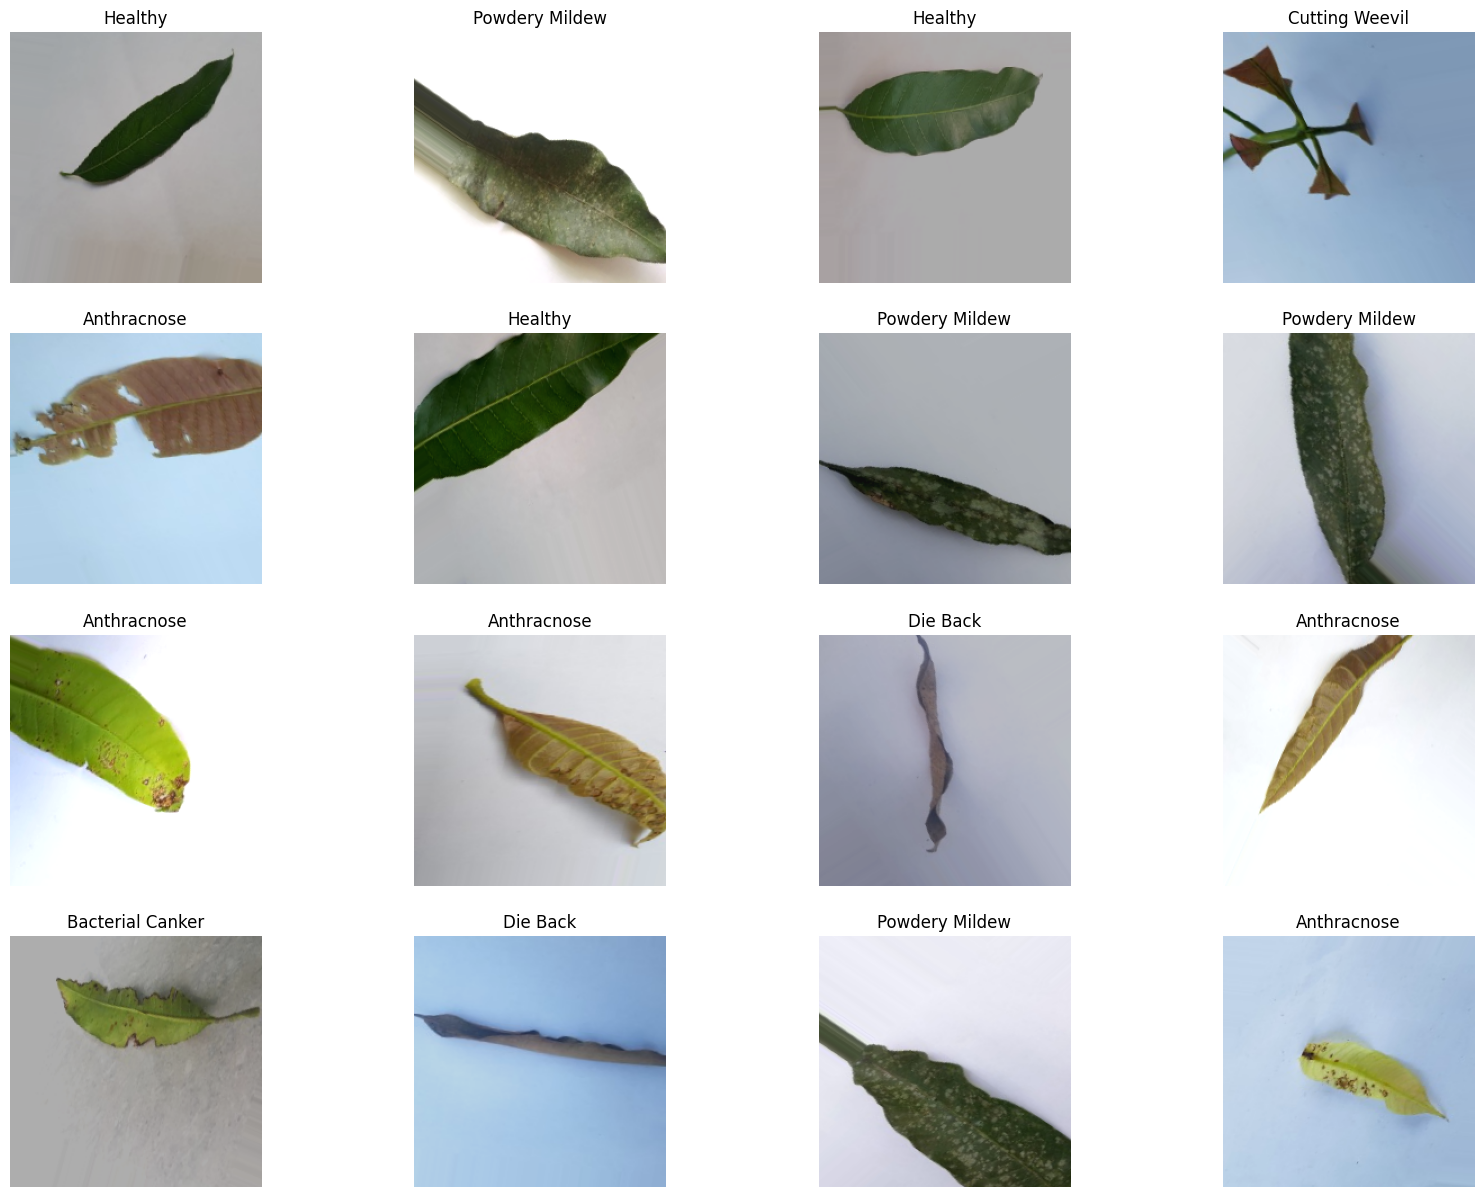

In [27]:
# Display 16 augmented images from the training set in a 4x4 grid with their class labels
plt.figure(figsize=(20, 15))

for i in range(16):
    if i >= len(images):
        break
    ax = plt.subplot(4, 4, i + 1)  # 4 rows, 4 columns = 16 images
    img = images[i] * 255.0
    plt.imshow(img.astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis('off')

plt.show()

In [28]:
# Train the ResNet50-based model with class weights and callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=epochs,
    verbose=1,
    callbacks=callbacks,
    class_weight=class_weight_dict
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.2110 - auc: 0.5840 - loss: 3.1650 - precision: 0.2448 - recall: 0.1179
Epoch 1: val_accuracy improved from -inf to 0.64000, saving model to best_CLDmodel_0109.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 85s 649ms/step - accuracy: 0.2122 - auc: 0.5851 - loss: 3.1576 - precision: 0.2465 - recall: 0.1185 - val_accuracy: 0.6400 - val_auc: 0.9259 - val_loss: 1.3786 - val_precision: 0.7703 - val_recall: 0.4275 - learning_rate: 2.0000e-05
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.6357 - auc: 0.9162 - loss: 1.4322 - precision: 0.7879 - recall: 0.4653
Epoch 2: val_accuracy improved from 0.64000 to 0.84750, saving model to best_CLDmodel_0109.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 54s 536ms/step - accuracy: 0.6363 - auc: 0.9164 - loss: 1.4310 - precision: 0.7882 - recall: 0.4660 - val_accuracy: 0.8475 - val_auc: 0.9858 - val_loss: 0.9675 - val_precision: 0.9172 - val_recall: 0.7750 - learning_rate: 4.0000e-05
Epoch 3

In [29]:
model.save('final_mango_model.keras')

In [30]:
#Model Evaluation
test_results = model.evaluate(test_generator)
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")
print(f"Test AUC: {test_results[2]:.4f}")
print(f"Test Precision: {test_results[3]:.4f}")
print(f"Test Recall: {test_results[4]:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9942 - auc: 0.9998 - loss: 0.6283 - precision: 0.9945 - recall: 0.9879
Test Loss: 0.6392
Test Accuracy: 0.9875
Test AUC: 0.9997
Test Precision: 0.9899
Test Recall: 0.9775


In [31]:
# Model Evaluation
# Evaluate the model on the validation set
# model.evaluate returns a list of values: [loss, accuracy, auc, precision, recall]
eval_results = model.evaluate(val_generator, verbose=1)
val_loss = eval_results[0]  # Loss is the first element
val_accuracy = eval_results[1]  # Accuracy is the second element
# ... (access other metrics similarly)

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


# Evaluate the model on the test set (if available)
eval_results = model.evaluate(test_generator, verbose=1)
test_loss = eval_results[0]  # Loss is the first element
test_accuracy = eval_results[1]  # Accuracy is the second element
# ... (access other metrics similarly)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 0.9982 - auc: 1.0000 - loss: 0.6334 - precision: 0.9982 - recall: 0.9810
Validation Loss: 0.6379110217094421
Validation Accuracy: 0.9975000023841858
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.9905 - auc: 0.9999 - loss: 0.6326 - precision: 0.9929 - recall: 0.9791
Test Loss: 0.6431582570075989
Test Accuracy: 0.9800000190734863


In [32]:
# Generate predictions for further analysis (optional)
y_pred = model.predict(test_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)  # Predicted classes
y_true = test_generator.classes  # True classes

# Generate a classification report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 378ms/step
                  precision    recall  f1-score   support

     Anthracnose       0.98      1.00      0.99        50
Bacterial Canker       1.00      1.00      1.00        50
  Cutting Weevil       1.00      1.00      1.00        50
        Die Back       0.98      0.96      0.97        50
      Gall Midge       1.00      0.98      0.99        50
         Healthy       0.96      0.98      0.97        50
  Powdery Mildew       0.98      0.98      0.98        50
     Sooty Mould       0.98      0.98      0.98        50

        accuracy                           0.98       400
       macro avg       0.99      0.98      0.98       400
    weighted avg       0.99      0.98      0.98       400



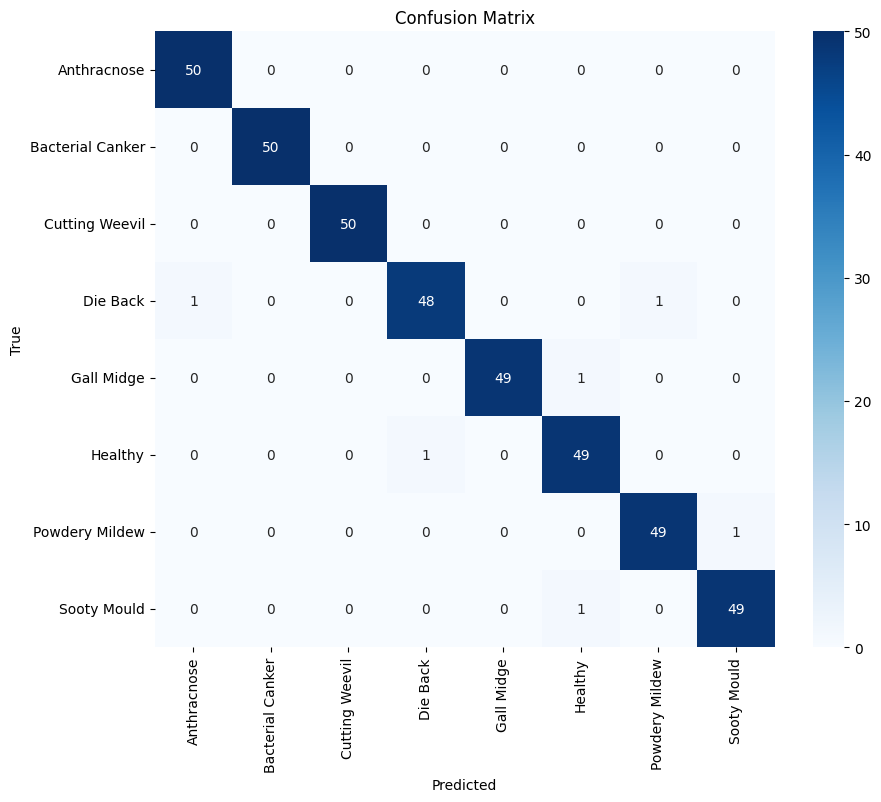

In [33]:
# Plot confusion matrix (optional, for better insights)
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

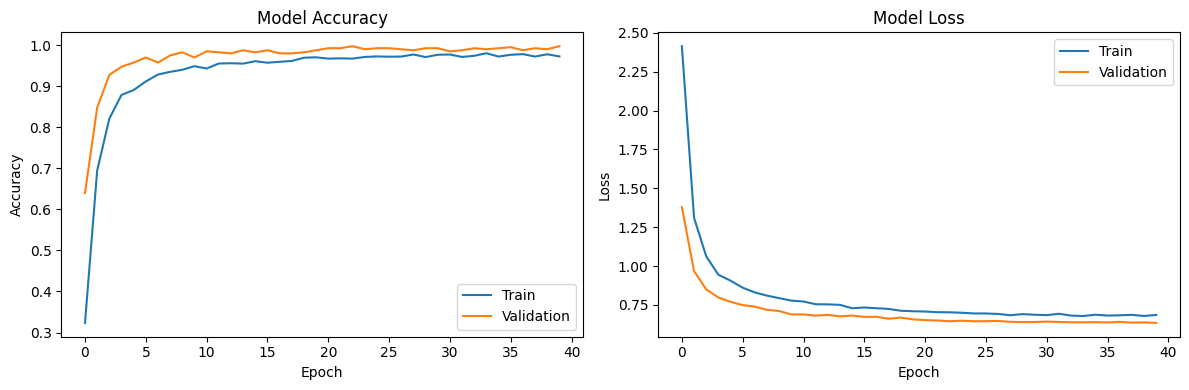

In [34]:
# Plot Training History
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step


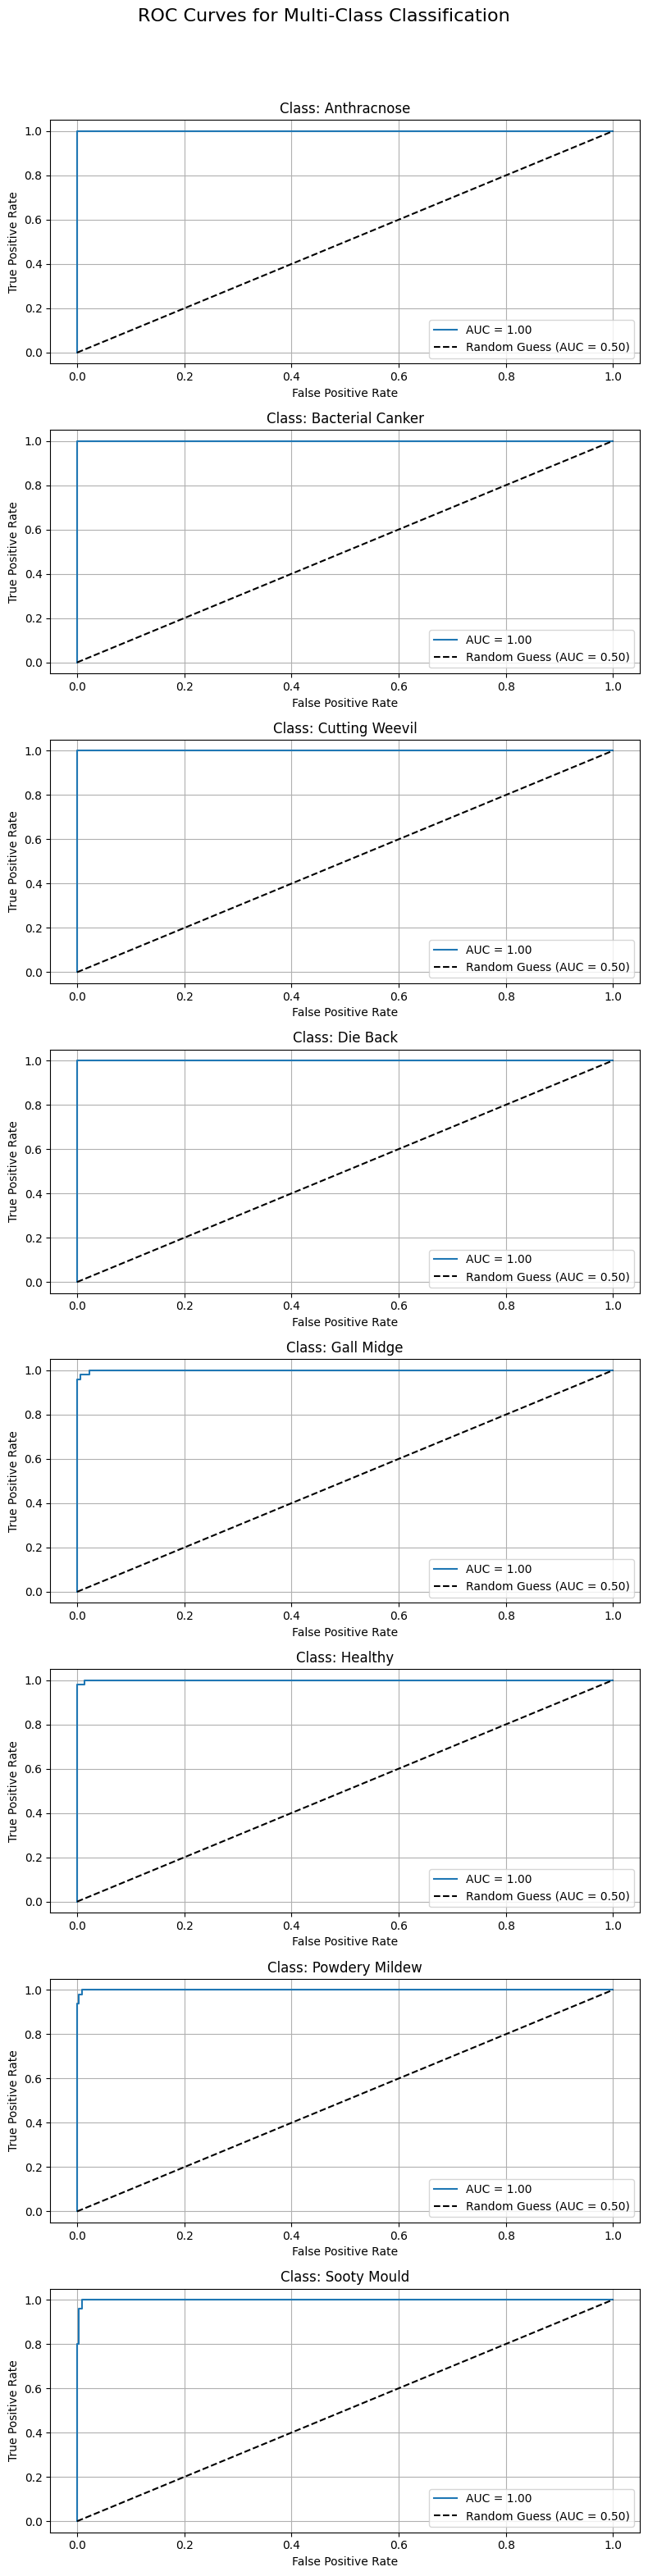

In [35]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the true labels for multi-class ROC
y_true_binarized = label_binarize(y_true, classes=list(range(len(test_generator.class_indices))))
n_classes = y_true_binarized.shape[1]

# Predict probabilities for the test set
y_pred_probs = model.predict(test_generator, verbose=1)

# Create subplots for ROC curves
fig, axes = plt.subplots(n_classes, 1, figsize=(8, n_classes * 4))
fig.suptitle("ROC Curves for Multi-Class Classification", fontsize=16)

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve in a separate subplot
    axes[i].plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    axes[i].plot([0, 1], [0, 1], "k--", label="Random Guess (AUC = 0.50)")
    axes[i].set_title(f"Class: {list(test_generator.class_indices.keys())[i]}")
    axes[i].set_xlabel("False Positive Rate")
    axes[i].set_ylabel("True Positive Rate")
    axes[i].legend(loc="lower right")
    axes[i].grid()

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the suptitle
plt.show()